In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import resample
import datetime
import seaborn as sns

import networkx as nx
import copy
import random
import getpass
import psycopg2 as ps
import os
import re
from scipy.stats import pearsonr

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.plotting import register_matplotlib_converters
from scipy.ndimage.filters import gaussian_filter1d
from matplotlib.dates import DateFormatter, DayLocator



C:\Users\Akshay\AppData\Local\Temp\ipykernel_27020\1631993729.py:19: DeprecationWarning: Please use `gaussian_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter1d


In [3]:
# Connecting to database
username = input("Username: ")
password = getpass.getpass()
pg_connection = ps.connect(
    dbname="don_hate", user=username, password=password, host="complex2.phys.gwu.edu"
)

# Query edges
with pg_connection.cursor() as cursor:
    cursor.execute(
        "select date_trunc('day', created_at at time zone 'utc') as ds, source_node as Source"
        + ", target_node as Target, source_sns as SNS_source, target_sns as SNS_target from hate_universe where created_at AT TIME ZONE 'utc' >= '2021-01-01'" 
    +"AND created_at AT TIME ZONE 'utc' < '2021-01-11'"
    )
    results = cursor.fetchall()
    Jan6 = pd.DataFrame(results, columns=["Day", "Source", "Target", "SNS Source", "SNS Target"])
# Query edges
with pg_connection.cursor() as cursor:
    cursor.execute(
        "select date_trunc('day', created_at at time zone 'utc') as ds, source_node as Source"
        + ", target_node as Target, source_sns as SNS_source, target_sns as SNS_target from hate_universe where created_at AT TIME ZONE 'utc' >= '2020-11-01'" 
    +"AND created_at AT TIME ZONE 'utc' < '2020-11-11'"
    )
    results = cursor.fetchall()
    Nov7 = pd.DataFrame(results, columns=["Day", "Source", "Target", "SNS Source", "SNS Target"])

In [4]:
Jan6 = Jan6.dropna(subset=['Target'])
Nov7 = Nov7.dropna(subset= ['Target'])
# Converting to Datetime format
Jan6['Day'] = pd.to_datetime(Jan6['Day'])
Nov7['Day'] = pd.to_datetime(Nov7['Day'])
# Group by 'Day' and count the number of rows for each day
daily_counts_Jan6 = Jan6.groupby('Day').size()
daily_counts_Nov7 = Nov7.groupby('Day').size()

# Calculate the increase relative to the first day
relative_increase_Jan6 = ((daily_counts_Jan6 - daily_counts_Jan6.iloc[0])/(daily_counts_Jan6.iloc[0]))*100.00
relative_increase_Nov7 = ((daily_counts_Nov7 - daily_counts_Nov7.iloc[0])/(daily_counts_Nov7.iloc[0]))*100.00

C:\Users\Akshay\AppData\Local\Temp\ipykernel_27020\1121262663.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.0f}%'.format(x) for x in plt.gca().get_yticks()])  # Add '%' symbol to y-axis labels


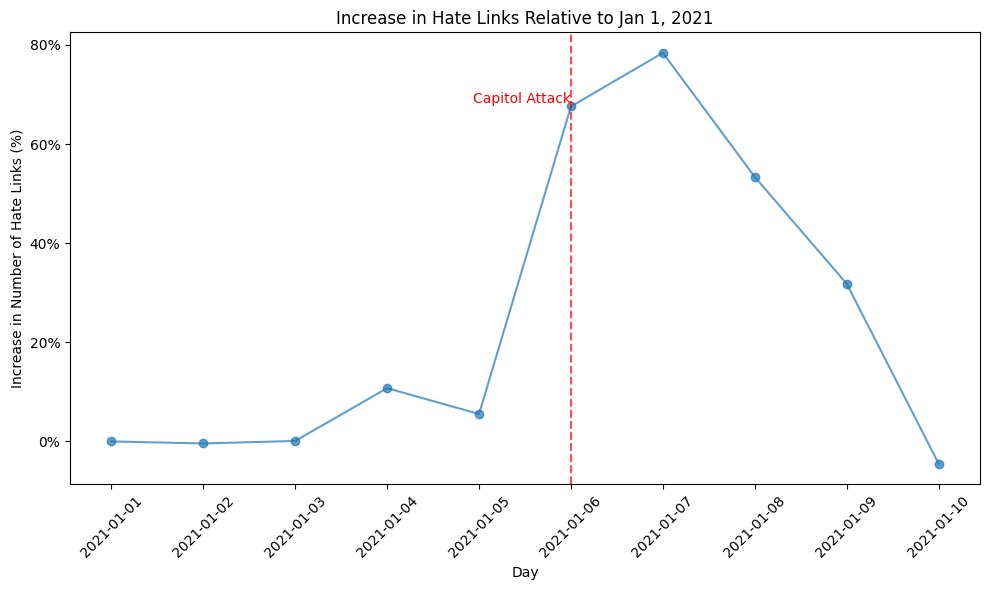

In [5]:
plt.figure(figsize=(10, 6))
plt.plot(relative_increase_Jan6.index, relative_increase_Jan6.values, marker='o', linestyle='-', alpha=0.7, markersize=6)
plt.axvline(x=pd.Timestamp('2021-01-06'), color='red', linestyle='--', alpha=0.7)
plt.text(pd.Timestamp('2021-01-06'), relative_increase_Jan6.loc['2021-01-06'], 'Capitol Attack', color='red', verticalalignment='bottom', horizontalalignment='right')
plt.title('Increase in Hate Links Relative to Jan 1, 2021')
plt.xlabel('Day')
plt.ylabel('Increase in Number of Hate Links (%)')
plt.xticks(rotation=45)
plt.gca().set_yticklabels(['{:.0f}%'.format(x) for x in plt.gca().get_yticks()])  # Add '%' symbol to y-axis labels
plt.tight_layout()
plt.grid(False)  # Removing gridlines

C:\Users\Akshay\AppData\Local\Temp\ipykernel_27020\4186470596.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.0f}%'.format(x) for x in plt.gca().get_yticks()])  # Add '%' symbol to y-axis labels


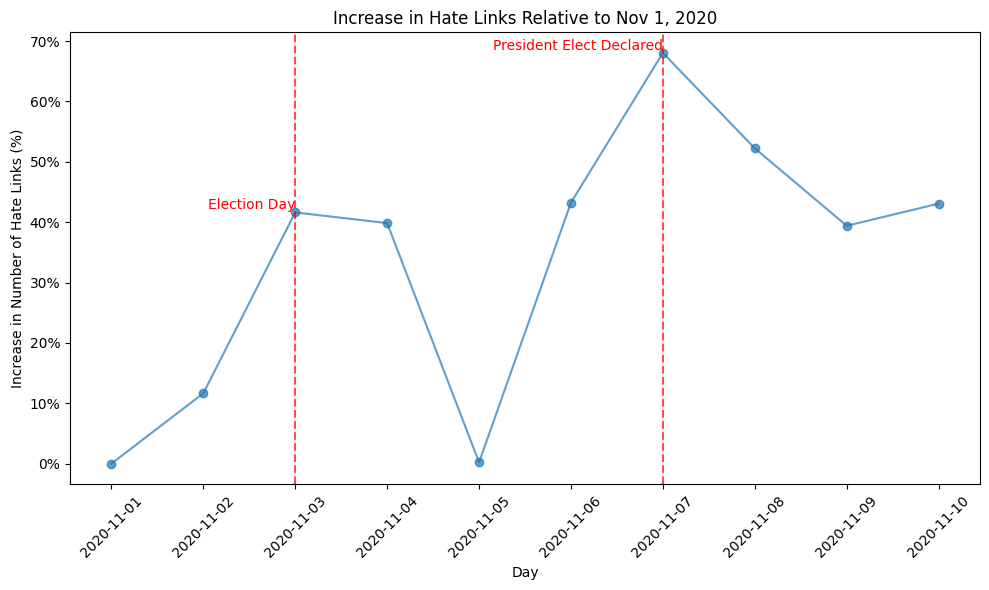

In [6]:
plt.figure(figsize=(10, 6))
plt.plot(relative_increase_Nov7.index, relative_increase_Nov7.values, marker='o', linestyle='-', alpha=0.7, markersize=6)
plt.axvline(x=pd.Timestamp('2020-11-03'), color='red', linestyle='--', alpha=0.7)

plt.axvline(x=pd.Timestamp('2020-11-07'), color='red', linestyle='--', alpha=0.7)
plt.text(pd.Timestamp('2020-11-03'), relative_increase_Nov7.loc['2020-11-03'], 'Election Day', color='red', verticalalignment='bottom', horizontalalignment='right')

plt.text(pd.Timestamp('2020-11-07'), relative_increase_Nov7.loc['2020-11-07'], 'President Elect Declared', color='red', verticalalignment='bottom', horizontalalignment='right')
plt.title('Increase in Hate Links Relative to Nov 1, 2020')
plt.xlabel('Day')
plt.ylabel('Increase in Number of Hate Links (%)')
plt.xticks(rotation=45)
plt.gca().set_yticklabels(['{:.0f}%'.format(x) for x in plt.gca().get_yticks()])  # Add '%' symbol to y-axis labels
plt.tight_layout()
plt.grid(False)  # Removing gridlines
plt.show()

In [27]:
# Connecting to database
username = input("Username: ")
password = getpass.getpass()
pg_connection = ps.connect(
    dbname="don_hate", user=username, password=password, host="complex2.phys.gwu.edu"
)

# Query edges
with pg_connection.cursor() as cursor:
    cursor.execute(
        "select date_trunc('day', created_at at time zone 'utc') as ds, source_node as Source"
        + ", target_node as Target, source_sns as SNS_source, target_sns as SNS_target from hate_universe where created_at AT TIME ZONE 'utc' >= '2020-11-01'" 
    +"AND created_at AT TIME ZONE 'utc' < '2020-11-03' AND target_unavailable = False;"
    )
    results = cursor.fetchall()
    pre_election = pd.DataFrame(results, columns=["Day", "Source", "Target", "SNS Source", "SNS Target"])

with pg_connection.cursor() as cursor:
    cursor.execute(
        "select date_trunc('day', created_at at time zone 'utc') as ds, source_node as Source"
        + ", target_node as Target, source_sns as SNS_source, target_sns as SNS_target from hate_universe where created_at AT TIME ZONE 'utc' >= '2020-11-03'" 
    +"AND created_at AT TIME ZONE 'utc' < '2020-11-05' AND target_unavailable = False;"
    )
    results = cursor.fetchall()
    post_election = pd.DataFrame(results, columns=["Day", "Source", "Target", "SNS Source", "SNS Target"])

# Query edges
with pg_connection.cursor() as cursor:
    cursor.execute(
        "select date_trunc('day', created_at at time zone 'utc') as ds, source_node as Source"
        + ", target_node as Target, source_sns as SNS_source, target_sns as SNS_target from hate_universe where created_at AT TIME ZONE 'utc' >= '2021-01-01'" 
    +"AND created_at AT TIME ZONE 'utc' <= '2021-01-05' AND target_unavailable = False;"
    )
    results = cursor.fetchall()
    pre_Jan6 = pd.DataFrame(results, columns=["Day", "Source", "Target", "SNS Source", "SNS Target"])

with pg_connection.cursor() as cursor:
    cursor.execute(
        "select date_trunc('day', created_at at time zone 'utc') as ds, source_node as Source"
        + ", target_node as Target, source_sns as SNS_source, target_sns as SNS_target from hate_universe where created_at AT TIME ZONE 'utc' >= '2021-01-06'" 
    +"AND created_at AT TIME ZONE 'utc' <= '2021-01-10' AND target_unavailable = False;"
    )
    results = cursor.fetchall()
    post_Jan6 = pd.DataFrame(results, columns=["Day", "Source", "Target", "SNS Source", "SNS Target"])

In [28]:
pre_election = pre_election.dropna(subset=['Target'])
post_election = post_election.dropna(subset= ['Target'])
pre_Jan6 = pre_Jan6.dropna(subset=['Target'])
post_Jan6 = post_Jan6.dropna(subset= ['Target'])

In [29]:
Graph_pre_Nov7= nx.from_pandas_edgelist(pre_election, 'Source', 'Target',  create_using=nx.Graph())
Graph_post_Nov7 = nx.from_pandas_edgelist(post_election, 'Source', 'Target',  create_using=nx.Graph())

In [30]:

def calculate_percentage_change(pre, post):
    return ((post - pre) / pre) * 100

# Calculate properties for Graph_pre_Jan6
pre_density = nx.density(Graph_pre_Nov7)
pre_cliques = list(nx.find_cliques(Graph_pre_Nov7))
pre_max_clique_size = max(len(clique) for clique in pre_cliques)
pre_num_communities = nx.number_connected_components(Graph_pre_Nov7)
pre_largest_community = max(len(c) for c in nx.connected_components(Graph_pre_Nov7))
pre_clustering_coefficient = nx.average_clustering(Graph_pre_Nov7)
pre_assortativity = nx.assortativity.degree_assortativity_coefficient(Graph_pre_Nov7)

# Calculate properties for Graph_post_Jan6
post_density = nx.density(Graph_post_Nov7)
post_cliques = list(nx.find_cliques(Graph_post_Nov7))
post_max_clique_size = max(len(clique) for clique in post_cliques)
post_num_communities = nx.number_connected_components(Graph_post_Nov7)
post_largest_community = max(len(c) for c in nx.connected_components(Graph_post_Nov7))
post_clustering_coefficient = nx.average_clustering(Graph_post_Nov7)
post_assortativity = nx.assortativity.degree_assortativity_coefficient(Graph_post_Nov7)

In [31]:
data = {
    'Property': ['Density', 'Number of Cliques', 'Max Clique Size', 'Number of Communities',
                 'Size of Largest Community', 'Clustering Coefficient', 'Assortativity'],
    'Pre_election': [pre_density, len(pre_cliques), pre_max_clique_size, pre_num_communities,
                 pre_largest_community, pre_clustering_coefficient, pre_assortativity],
    'Post_election': [post_density, len(post_cliques), post_max_clique_size, post_num_communities,
                  post_largest_community, post_clustering_coefficient, post_assortativity]
}

df = pd.DataFrame(data)

for prop in data['Property']:
    pre_value = df.loc[df['Property'] == prop, 'Pre_election'].values[0]
    post_value = df.loc[df['Property'] == prop, 'Post_election'].values[0]
    percentage_change = calculate_percentage_change(pre_value, post_value)
    df.loc[df['Property'] == prop, 'Percentage Change'] = percentage_change


# Display the DataFrame
print(df)

                    Property  Pre_election  Post_election  Percentage Change
0                    Density      0.000489       0.000472          -3.588254
1          Number of Cliques   4841.000000    5442.000000          12.414790
2            Max Clique Size      4.000000       5.000000          25.000000
3      Number of Communities     70.000000      68.000000          -2.857143
4  Size of Largest Community   4334.000000    4726.000000           9.044762
5     Clustering Coefficient      0.012397       0.013940          12.446308
6              Assortativity     -0.518463      -0.490817          -5.332202


In [78]:
Graph_pre_Jan6 = nx.from_pandas_edgelist(pre_Jan6, 'Source', 'Target',  create_using=nx.Graph())
Graph_post_Jan6 = nx.from_pandas_edgelist(post_Jan6, 'Source', 'Target',  create_using=nx.Graph())

In [79]:
# Calculate properties for Graph_pre_Jan6
pre_density = nx.density(Graph_pre_Jan6)
pre_cliques = list(nx.find_cliques(Graph_pre_Jan6))
pre_max_clique_size = max(len(clique) for clique in pre_cliques)
pre_num_communities = nx.number_connected_components(Graph_pre_Jan6)
pre_largest_community = max(len(c) for c in nx.connected_components(Graph_pre_Jan6))
pre_clustering_coefficient = nx.average_clustering(Graph_pre_Jan6)
pre_assortativity = nx.assortativity.degree_assortativity_coefficient(Graph_pre_Jan6)

# Calculate properties for Graph_post_Jan6
post_density = nx.density(Graph_post_Jan6)
post_cliques = list(nx.find_cliques(Graph_post_Jan6))
post_max_clique_size = max(len(clique) for clique in post_cliques)
post_num_communities = nx.number_connected_components(Graph_post_Jan6)
post_largest_community = max(len(c) for c in nx.connected_components(Graph_post_Jan6))
post_clustering_coefficient = nx.average_clustering(Graph_post_Jan6)
post_assortativity = nx.assortativity.degree_assortativity_coefficient(Graph_post_Jan6)


In [80]:
data = {
    'Property': ['Density', 'Number of Cliques', 'Max Clique Size', 'Number of Communities',
                 'Size of Largest Community', 'Clustering Coefficient', 'Assortativity'],
    'Pre_Jan6': [pre_density, len(pre_cliques), pre_max_clique_size, pre_num_communities,
                 pre_largest_community, pre_clustering_coefficient, pre_assortativity],
    'Post_Jan6': [post_density, len(post_cliques), post_max_clique_size, post_num_communities,
                  post_largest_community, post_clustering_coefficient, post_assortativity]
}

df = pd.DataFrame(data)

for prop in data['Property']:
    pre_value = df.loc[df['Property'] == prop, 'Pre_Jan6'].values[0]
    post_value = df.loc[df['Property'] == prop, 'Post_Jan6'].values[0]
    percentage_change = calculate_percentage_change(pre_value, post_value)
    df.loc[df['Property'] == prop, 'Percentage Change'] = percentage_change


# Display the DataFrame
print(df)

                    Property     Pre_Jan6    Post_Jan6  Percentage Change
0                    Density     0.000371     0.000349          -5.871250
1          Number of Cliques  6417.000000  8610.000000          34.174848
2            Max Clique Size     5.000000     5.000000           0.000000
3      Number of Communities   115.000000    86.000000         -25.217391
4  Size of Largest Community  5632.000000  7068.000000          25.497159
5     Clustering Coefficient     0.011040     0.028610         159.155468
6              Assortativity    -0.494335    -0.370120         -25.127703


## Experimentation



In [35]:
# Connecting to database
username = input("Username: ")
password = getpass.getpass()
pg_connection = ps.connect(
    dbname="don_hate", user=username, password=password, host="complex2.phys.gwu.edu"
)

# Query edges
with pg_connection.cursor() as cursor:
    cursor.execute(
        "select date_trunc('day', created_at at time zone 'utc') as ds, source_node as Source"
        + ", target_node as Target, source_sns as SNS_source, target_sns as SNS_target from hate_universe where created_at AT TIME ZONE 'utc' >= '2020-01-01'" 
    +"AND created_at AT TIME ZONE 'utc' < '2022-12-12'"
    )
    results = cursor.fetchall()
    Network = pd.DataFrame(results, columns=["Day", "Source", "Target", "SNS Source", "SNS Target"])

In [37]:
Network = Network.dropna(subset=['Target'])


In [36]:
selected_intervals = []
for _ in range(50):
    start_date = np.random.choice(Network['Day'].dt.strftime('%Y-%m-%d').unique())
    start_date = pd.to_datetime(start_date)
    end_date = start_date + pd.Timedelta(days=9)
    selected_intervals.append((start_date, end_date))


In [61]:
def calculate_graph_metrics(data):
    graph = nx.from_pandas_edgelist(data, 'Source', 'Target', create_using=nx.Graph())
    density = nx.density(graph)

    num_communities = nx.number_connected_components(graph)
    largest_community = max(len(c) for c in nx.connected_components(graph))
    clustering_coefficient = nx.average_clustering(graph)
    assortativity = nx.assortativity.degree_assortativity_coefficient(graph) #Giving negative value cause network is diassortative, so to find the % increase we need to add a negative sign to the denmoinator
    
    return density,   num_communities, largest_community, clustering_coefficient, assortativity

In [62]:
random_intervals_metrics = []
for interval in selected_intervals:
    start_date, end_date = interval
    # Split the interval into two parts
    mid_date = start_date + pd.Timedelta(days=4)  # Adjust this to your preferred split point
    first_part_data = Network[(Network['Day'] >= start_date) & (Network['Day'] <= mid_date)]
    second_part_data = Network[(Network['Day'] > mid_date) & (Network['Day'] <= end_date)]
    
    # Calculate metrics for the two parts
    first_part_metrics = calculate_graph_metrics(first_part_data)
    second_part_metrics = calculate_graph_metrics(second_part_data)
    # Calculate percentage increase from the first part to the second
    percentage_increase = []
    for first, second in zip(first_part_metrics, second_part_metrics):
        if isinstance(first, list) and isinstance(second, list):
            # If the metric is a list, calculate the percentage increase for each element
            increase = [(s - f) / f * 100 if f != 0 else 0 for f, s in zip(first, second)]
        else:
            # If the metric is a single value, calculate the percentage increase directly
            increase = (second - first) / first * 100 if first != 0 else 0
        
        percentage_increase.append(increase)
    
    random_intervals_metrics.append(percentage_increase)

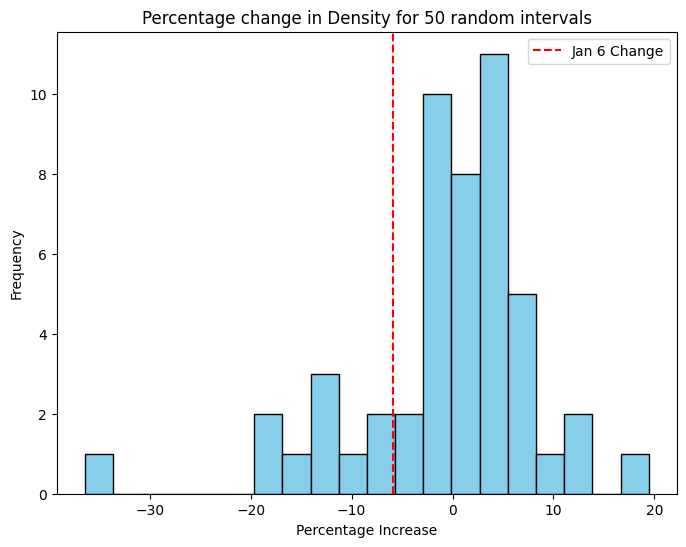

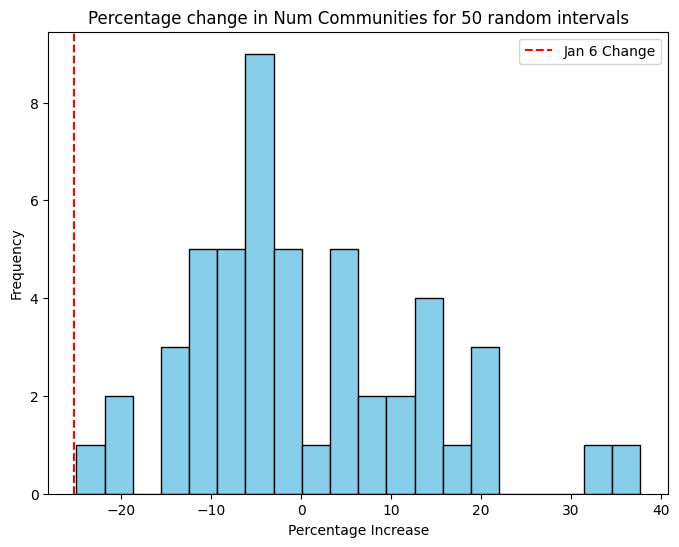

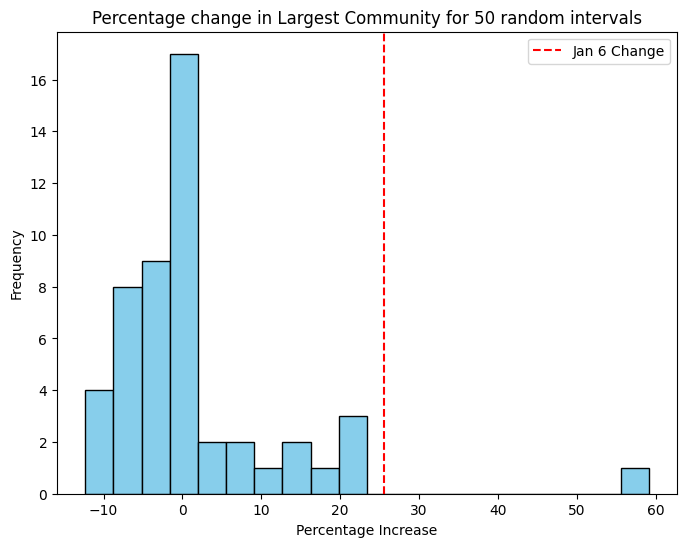

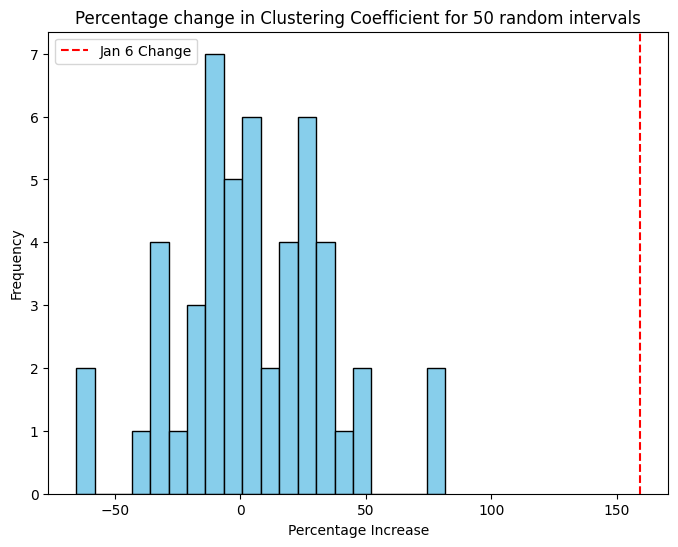

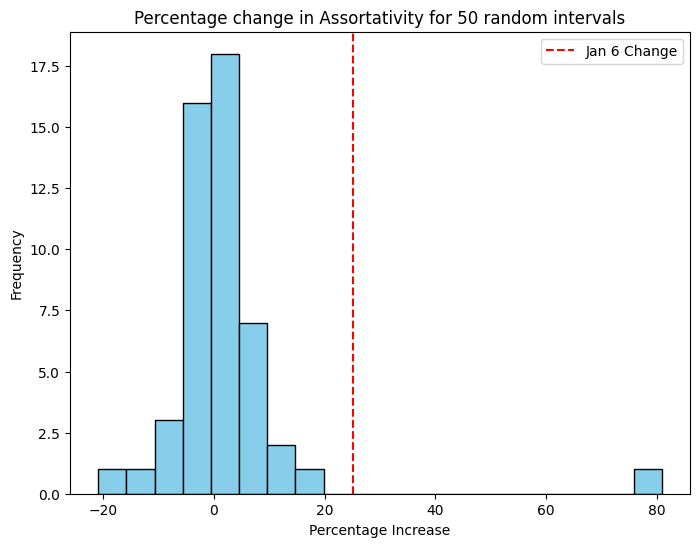

In [63]:
metric_names = ['Density',  'Num Communities', 'Largest Community', 'Clustering Coefficient', 'Assortativity']

property_values = {
    'Density': -5.871250,
    'Num Communities': -25.217391,
    'Largest Community': 25.497159,
    'Clustering Coefficient': 159.155468,
    'Assortativity': 25.127703
}

# Plotting separate histograms for each metric
for i, metric in enumerate(metric_names):
    plt.figure(figsize=(8, 6))
    plt.hist([sublist[i] for sublist in random_intervals_metrics], bins=20, color='skyblue', edgecolor='black')
    plt.xlabel('Percentage Increase')
    plt.ylabel('Frequency')
    plt.title(f'Percentage change in {metric} for 50 random intervals')
    plt.grid(False)
    
    # Add vertical line for provided property value
    if metric in property_values:
        plt.axvline(x=property_values[metric], color='red', linestyle='--', label='Jan 6 Change')
        plt.legend()
    
    plt.show()



## Hate Type

In [ ]:
# Connecting to database
username = input("Username: ")
password = getpass.getpass()
pg_connection = ps.connect(
    dbname="don_hate", user=username, password=password, host="complex2.phys.gwu.edu"
)

# Query edges
with pg_connection.cursor() as cursor:
    cursor.execute(
        "Select date_trunc('day', h.created_at at time zone 'utc') as ds, source_node, target_node, source_sns, target_sns,  religion_prediction, race_prediction, gender_prediction, giso_prediction,"
        +"immigration_prediction, ein_prediction, antisemitism_prediction, target_hate from hate_universe h LEFT JOIN flavors f ON h.source_don_id = f.don_id  "
        +"WHERE h.created_at AT TIME ZONE 'utc' >= '2020-11-01' and h.created_at AT TIME ZONE 'utc' <  '2021-01-11' AND target_unavailable = False;"
    )
    results = cursor.fetchall()
    df_jan6 = pd.DataFrame(results, columns=["Day", "Source", "Target", "SNS Source", "SNS Target",  "religion_prediction","race_prediction", "gender_prediction", "giso_prediction", "immigration_prediction", "ein_prediction", "antisemitism_prediction", "hate_core" ])

with pg_connection.cursor() as cursor:
    cursor.execute(
        "Select date_trunc('day', h.created_at at time zone 'utc') as ds, source_node, target_node, source_sns, target_sns,  religion_prediction, race_prediction, gender_prediction, giso_prediction,"
        +"immigration_prediction, ein_prediction, antisemitism_prediction, target_hate from hate_universe h LEFT JOIN flavors f ON h.source_don_id = f.don_id  "
        +"WHERE h.created_at AT TIME ZONE 'utc' >= '2020-11-02' and h.created_at AT TIME ZONE 'utc' <  '2020-11-12' AND target_unavailable = False;"
    )
    results = cursor.fetchall()
    df_Nov7 = pd.DataFrame(results, columns=["Day", "Source", "Target", "SNS Source", "SNS Target",  "religion_prediction","race_prediction", "gender_prediction", "giso_prediction", "immigration_prediction", "ein_prediction", "antisemitism_prediction", "hate_core" ])




In [ ]:
Pre_jan6 = df_jan6[(df_jan6['Day'] >= '2021-01-01') & (df_jan6['Day'] <= '2021-01-05')]
Post_jan6 = df_jan6[(df_jan6['Day'] >= '2021-01-06') & (df_jan6['Day'] <= '2021-01-10')]
Pre_Nov7 = df_Nov7[(df_Nov7['Day'] >= '2020-11-02') & (df_Nov7['Day'] <= '2020-11-06')]
Post_Nov7 = df_Nov7[(df_Nov7['Day'] >= '2020-11-07') & (df_Nov7['Day'] <= '2020-11-11')]

In [ ]:
boolean_columns = ['religion_prediction', 'race_prediction', 'gender_prediction',
                   'giso_prediction', 'immigration_prediction', 'ein_prediction', 
                   'antisemitism_prediction', 'SNS Source']

# Group by 'SNS' column and sum the boolean columns
hate_counts_pre = pre_Jan6[boolean_columns].groupby('SNS Source').sum()

# Group by 'SNS' column and sum the boolean columns
hate_counts_post = post_Jan6[boolean_columns].groupby('SNS Source').sum()

# Display the counts of hate types for each SNS
hate_counts_post

In [ ]:
percentage_change = ((hate_counts_post - hate_counts_pre) / hate_counts_pre) * 100
percentage_change

In [ ]:
total_pre = hate_counts_pre.sum()
total_post = hate_counts_post.sum()

# Calculate the percentage change without considering the SNS
percentage_change_total = ((total_post - total_pre) / total_pre) * 100

# Display the percentage change
print(percentage_change_total)

In [ ]:
# Remove "prediction" and replace it with "hate" in the x-axis labels
x_labels = [label.replace('_prediction', ' Hate') for label in percentage_change_total.index]
# Plotting the percentage change
# Plotting the percentage change
plt.figure(figsize=(10, 6))
percentage_change_total.plot(kind='bar', color='skyblue')
plt.title('Change in Hate Type after January 6 Capitol attack')
plt.ylabel('Percentage Increase (%)')
plt.xticks(range(len(x_labels)), x_labels, rotation=0, ha='center')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
boolean_columns = ['religion_prediction', 'race_prediction', 'gender_prediction',
                   'giso_prediction', 'immigration_prediction', 'ein_prediction', 
                   'antisemitism_prediction', 'SNS Source']

# Group by 'SNS' column and sum the boolean columns
hate_counts_pre = Pre_Nov7[boolean_columns].groupby('SNS Source').sum()

# Group by 'SNS' column and sum the boolean columns
hate_counts_post = Post_Nov7[boolean_columns].groupby('SNS Source').sum()

# Display the counts of hate types for each SNS
hate_counts_post

## Correlation 


In [ ]:
# Connecting to database
username = input("Username: ")
password = getpass.getpass()
pg_connection = ps.connect(
    dbname="don_hate", user=username, password=password, host="complex2.phys.gwu.edu"
)

# Query edges
with pg_connection.cursor() as cursor:
    cursor.execute(
        "select date_trunc('day', created_at at time zone 'utc') as ds, source_node as Source"
        + ", target_node as Target, source_sns as SNS_source, target_sns as SNS_target from hate_universe where created_at AT TIME ZONE 'utc' >= '2020-11-01'" 
    +"AND created_at AT TIME ZONE 'utc' < '2021-01-10' and target_unavailable = False;"
    )
    results = cursor.fetchall()
    Hate_Universe = pd.DataFrame(results, columns=["Day", "Source", "Target", "SNS Source", "SNS Target"])

In [ ]:
# Connecting to database
username = input("Username: ")
password = getpass.getpass()
pg_connection = ps.connect(
    dbname="don_hate", user=username, password=password, host="complex2.phys.gwu.edu"
)

# Query edges
with pg_connection.cursor() as cursor:
    cursor.execute(
        "select date_trunc('day', f.created_at at time zone 'utc'),  religion_prediction, race_prediction, gender_prediction, giso_prediction, immigration_prediction, ein_prediction, antisemitism_prediction,f.sns from flavors as f  WHERE f.created_at AT TIME ZONE 'utc' >= '2020-11-01' AND f.created_at AT TIME ZONE 'utc' < '2021-01-10' ;"
    )
    results = cursor.fetchall()
    df_flavor = pd.DataFrame(results, columns=["Day", "Religion hate","Race hate", "Gender hate", "GISO hate", "Immigration hate", "EIN hate", "Antisemitism","SNS" ])

In [ ]:
# List of prediction columns
prediction_columns =  ["Religion hate","Race hate", "Gender hate", "GISO hate", "Immigration hate", "EIN hate", "Antisemitism"]

Daily_count_flavors_df = pd.DataFrame()
for column in prediction_columns:
    
    # Filter DataFrame to get rows where the current column is True, then group by day and get the size of each group
    true_counts = df_flavor[df_flavor[column]].groupby('Day').size()
    Daily_count_flavors_df[column] = true_counts
    

SNS_columns  = Hate_Universe['SNS Source'].unique().tolist()
print(SNS_columns)
Daily_count_sns_df = pd.DataFrame()

for column in SNS_columns:

    true_counts = Hate_Universe[Hate_Universe['SNS Source'] == column].groupby('Day').size()
    Daily_count_sns_df[column] = true_counts
    



In [ ]:

correlations = {}
for col1 in Daily_count_flavors_df.columns:
    for col2 in Daily_count_sns_df.columns:
        correlation = Daily_count_flavors_df[col1].corr(Daily_count_sns_df[col2])
        correlations[(col1, col2)] = correlation

for pair, correlation in correlations.items():
    print(f"Correlation between {pair[0]} and {pair[1]}: {correlation}")

In [ ]:
columns1, columns2 = zip(*correlations.keys())

# Extract correlation values
correlation_values = list(correlations.values())

# Create a DataFrame from the correlation values with columns as the original column names
correlation_df = pd.DataFrame({'Column1': columns1, 'Column2': columns2, 'Correlation': correlation_values})

# Pivot the DataFrame to create a correlation matrix
correlation_matrix = correlation_df.pivot('Column1', 'Column2', 'Correlation')

# Remove the 'Instagram' column and row from the correlation matrix

correlation_matrix = correlation_matrix.drop('Instagram', axis=1)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap between daily edge and hate type count across different SNS')
plt.xlabel('Social Networking Site')
plt.ylabel('Hate Type Detected')
plt.show()